the most distinguished parameter that distinghuishs the ASD vs control.

define a midpoint
vary by d1,d2, where d1,d2 is delta theta in the interested direction
calcualte the logll for ASD and healthy seperatly, add together.
final result is a heat map

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import os
import pandas as pd
import numpy as np
from cmaes import CMA
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import torch
import heapq
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt
import time
from stable_baselines3 import TD3
torch.manual_seed(0)
from numpy import linspace, pi
from InverseFuncs import *
from monkey_functions import *
from firefly_task import ffacc_real
from env_config import Config
# from cma_mpi_helper import run
import ray
from pathlib import Path
arg = Config()
import os
from timeit import default_timer as timer
from plot_ult import *
from scipy.ndimage.filters import gaussian_filter

import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
datafolder=config['Datafolder']['data']
datapath=Path(datafolder)

In [2]:

# load agent and task 
env=ffacc_real.FireFlyPaper(arg)
env.episode_len=50
env.debug=1
env.terminal_vel=0.2
phi=torch.tensor([[1],
            [pi/2],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
            [0.13],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
    ])
agent_=TD3.load('trained_agent/paper.zip')
agent=agent_.actor.mu.cpu()

In [3]:

# define the midpoint between ASD and healthy 
logls=[datapath/'human/fixragroup',datapath/'human/clusterpaperhgroup']
monkeynames=['ASD', 'Ctrl' ]

mus,covs,errs=[],[],[]
thetas=[]
for inv in logls:
    finaltheta,finalcov, err=process_inv(inv,ind=60,removegr=False)
    mus.append(np.array(finaltheta).reshape(-1))
    covs.append(finalcov)
    errs.append(err)
    thetas.append(finaltheta)
thetas=torch.tensor(mus)
theta_init=thetas[0]
theta_final=thetas[1]

# load theta distribution
alltag=[]
alltheta=[]
loglls=[]
with open(logls[0],'rb') as f:
    log=pickle.load(f)
    res=[l[2] for l in log[19:99]]
    for r in res:
        for point in r:
            alltheta.append(point[0]) # theta
            loglls.append(point[1])
            alltag.append(0)
with open(logls[1],'rb') as f:
    log=pickle.load(f)
    res=[l[2] for l in log[19:99]]
    for r in res:
        for point in r:
            alltheta.append(point[0]) # theta
            loglls.append(point[1])
            alltag.append(1)

alltheta=np.array(alltheta)
alltag=np.array(alltag)

/Users/yc/Documents/lab_data/human/fixragroup
using ind:  60 final logll :  10.684259755270821
/Users/yc/Documents/lab_data/human/clusterpaperhgroup
using ind:  60 final logll :  8.739409999999998


In [4]:
# compute svm
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(alltheta, alltag)
w = clf.coef_[0] # the normal vector
midpoint=(mus[0]+mus[1])/2
lb=np.array([0,0,0,0,0,0,0.129,0,0,0,0])
hb=np.array([1,2,1,1,1,1,0.131,2,2,1,1])

theta_init=np.min(midpoint-lb)/w[np.argmin(hb-midpoint)]*-w*3+midpoint
theta_final=np.min(midpoint-lb)/w[np.argmin(midpoint-lb)]*w*3+midpoint
theta_init,theta_final=torch.tensor(theta_init).view(-1,1).float(),torch.tensor(theta_final).view(-1,1).float()



In [6]:
# function to eval the logll of the delta theta
gridreso=11
num_sample=200
# load the data
thisdatapath=datapath/("human/hgroup")
with open(thisdatapath, 'rb') as f:
    hstates, hactions, htasks = pickle.load(f)
thisdatapath=Path(datapath/"human/agroup")
with open(thisdatapath, 'rb') as f:
    astates, aactions, atasks = pickle.load(f)
# select the side tasks
hstates, hactions, htasks=select_tar(hstates, hactions, htasks)
astates, aactions, atasks=select_tar(astates, aactions, atasks)
# randomly select some data
hstates, hactions, htasks=hstates[:num_sample], hactions[:num_sample], htasks[:num_sample].astype('float32')
astates, aactions, atasks=astates[:num_sample], aactions[:num_sample], atasks[:num_sample].astype('float32')

ray.init(log_to_driver=False,ignore_reinit_error=True)
@ray.remote
def getlogll(x):
    atheta,htheta=x[0],x[1]
    atheta.clamp_(1e-3,3)
    htheta.clamp_(1e-3,3)
    with torch.no_grad():
        lla=monkeyloss_(agent, aactions, atasks, phi, atheta, env, action_var=0.001,num_iteration=1, states=astates, samples=5,gpu=False,debug=False)
        llh=monkeyloss_(agent, hactions, htasks, phi, htheta, env, action_var=0.001,num_iteration=1, states=hstates, samples=5,gpu=False,debug=False)
        return -lla-llh
    
'''
complexity:
gridreso**2 *(ntrialT * nsample) * 2
'''

[   4   11   33   40   41   42   43   47   56   58   59   64   69   73
   82   88   94   98  101  103  106  107  110  111  112  116  118  126
  128  138  152  160  161  177  183  186  191  196  197  207  209  218
  223  224  225  237  242  248  258  276  278  280  289  294  298  303
  305  309  313  315  321  322  329  331  333  343  354  355  361  364
  366  370  378  382  385  386  391  396  403  420  422  424  431  436
  440  442  444  448  453  458  459  466  467  475  478  487  499  500
  505  506  510  511  516  527  528  532  536  541  553  561  564  566
  570  578  582  584  590  598  599  615  621  625  630  635  636  646
  656  661  662  663  674  679  685  696  714  716  718  727  732  737
  745  760  766  770  775  780  781  791  793  801  806  807  808  820
  825  831  842  860  862  864  873  878  887  892  893  896  897  898
  901  902  909  913  916  917  923  928  933  937  939  944  948  956
  960  963  965  967  976  978  979  981  989 1000 1002 1005 1016 1024
 1028 

2024-07-18 14:28:04,391	INFO worker.py:1788 -- Started a local Ray instance.


'\ncomplexity:\ngridreso**2 *(ntrialT * nsample) * 2\n'

In [7]:

# vary noise and gain -------------------------------
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1 # noise
dy[1]=1 # gain
X,Y=np.linspace(-0.7,0.7,gridreso), np.linspace(-0.45,0.45,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        atheta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        htheta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        # eval the logll
        # Z[i,j]=atheta,htheta
        paramls.append([atheta,htheta])

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZnoisecost3finer19', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:

# vary noise and cost -------------------------------
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1 # noise
dy[8]=1 # cost
X,Y=np.linspace(-0.7,0.7,gridreso), np.linspace(-0.45,0.45,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        atheta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        htheta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        # eval the logll
        # Z[i,j]=atheta,htheta
        paramls.append([atheta,htheta])

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZnoisecost3finer19', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
with open(datapath/'human/jointlikelihood/distinguishparamZnoisecost3finer19', 'rb') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
truedelta=mus[1]-mus[0]

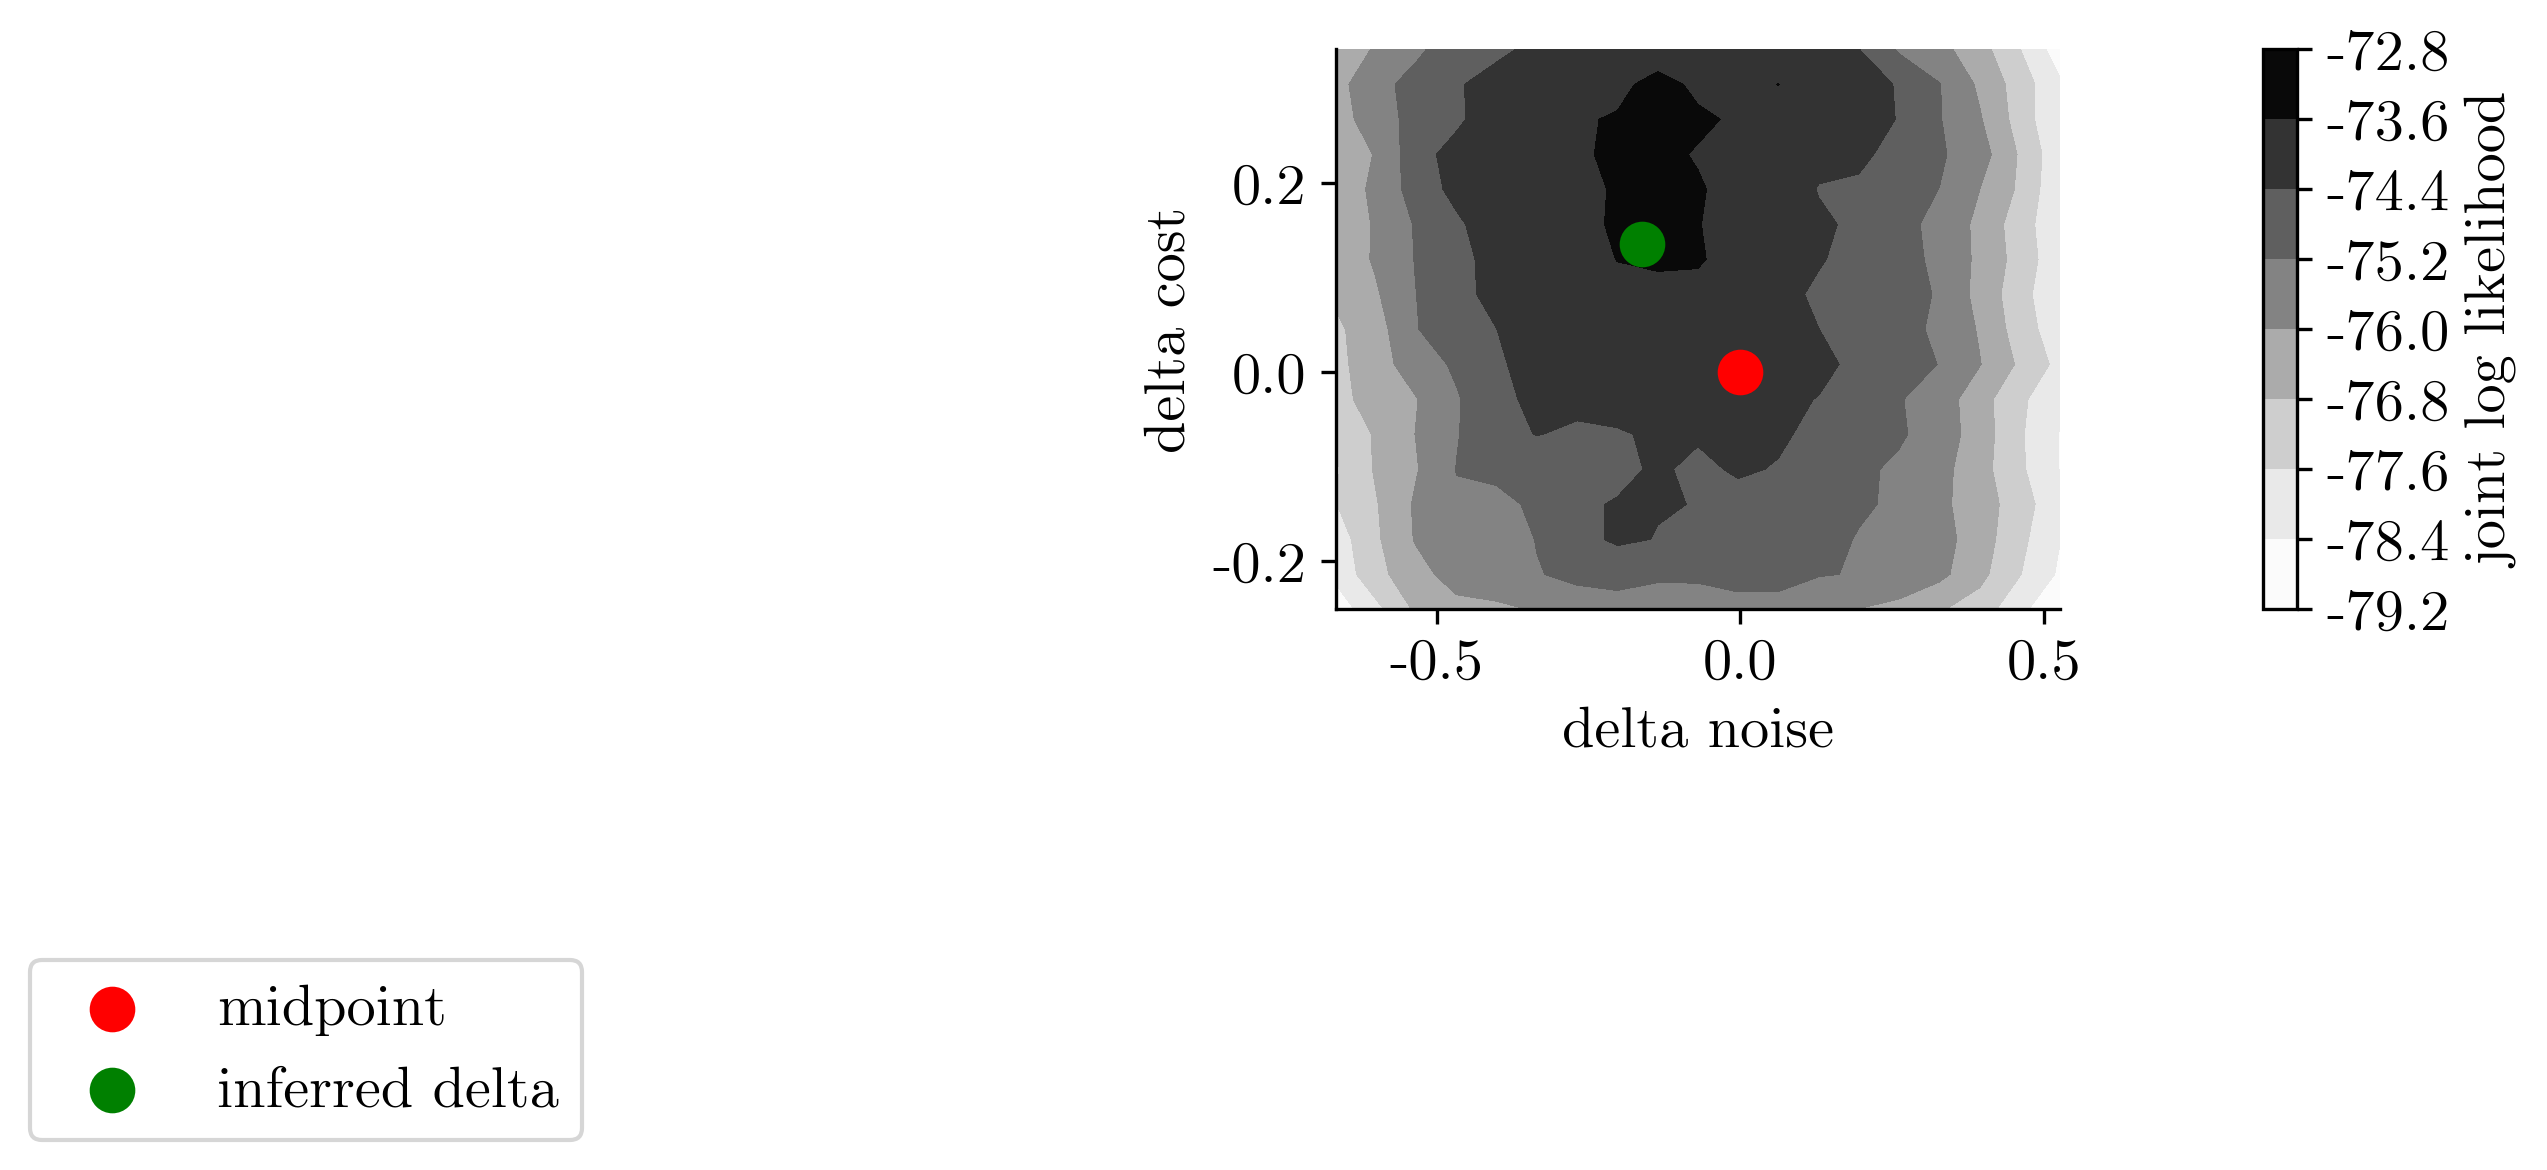

In [10]:
from scipy.ndimage.filters import gaussian_filter
sigma = 0.5
formatedZ = gaussian_filter(formatedZ, sigma)

with initiate_plot(5,5,300) as f:
    ax=f.add_subplot(111)
    # im=ax.imshow(formatedZ[1:-1],origin='lower', extent=(X[0],X[-2],Y[2],Y[-2]),aspect=(X[-2]-X[0])/(Y[-2]-Y[0]),vmin=-79, vmax=-73, cmap='jet')    
    im=ax.contourf(formatedZ[1:-1],origin='lower', extent=(X[0],X[-2],Y[2],Y[-2]),aspect=(X[-2]-X[0])/(Y[-2]-Y[0]),vmin=-79, vmax=-73, cmap='Greys')    
    ax.set_aspect((X[-2]-X[0])/(Y[-2]-Y[0]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.005)
    plt.colorbar(im, cax=cax,label='joint log likelihood')
    ax.scatter(0,0,label='midpoint', color='r',s=99) # midpoint, 0,0
    ax.set_xlabel('delta noise')
    ax.set_ylabel('delta cost')
    ax.scatter(truedelta[5]/2,truedelta[8]/2,label='inferred delta', color='green',s=99) # inferred delta
    quickleg(ax)
    quickspine(ax)
    # quicksave('joint likelihood noise and cost')


In [11]:

# prediciton over obs 1d ---------------------------------
# vary obs noise, while try to keep simlar uncertainty and same bias
'''
constaints:
1, total uncertainty same. po/(p+o)=c
2, biased degree same. (1-k)*g, 
where k=p/(p+o), p and o are uncertainty variance 
'''
def totalbias(g,p,o):
    return g*(p**2/(p**2+o**2))
def totalgivenop(a,b):
    return (a**2)*(b**2)/((a**2)+(b**2))
def pogiventotal(a, c):
    return ((a**2)*c/((a**2)-c))**0.5


dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=0.3 # noise
# dy[8]=0.45 # 
auncertainty=mus[0][5]**2*mus[0][3]**2/(mus[0][5]**2+mus[0][3]**2)
huncertainty=(mus[1][5]**2*mus[1][3]**2)/(mus[1][5]**2+mus[1][3]**2)
abias=totalbias(mus[0][1],mus[0][3],mus[0][5])
hbias=totalbias(mus[1][1],mus[1][3],mus[1][5])

c=totalgivenop(mus[0][5],mus[0][3])
# pogiventotal(mus[0][5],auncertainty)

X,Y=np.linspace(-1,1,gridreso), np.linspace(-1,1,gridreso)
paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        # calcualte the dy, keep uncertainty same
        anewparam_=torch.tensor(-dx*X[i]+midpoint).float().view(-1,1)
        anewpnoise=pogiventotal(anewparam_[5],auncertainty)
        anewk = anewpnoise**2 / (anewparam_[5]**2+anewpnoise**2)
        anewg=abias/anewk
        anewparam_[3]=anewpnoise
        anewparam_[1]=anewg


        hnewparam_=torch.tensor(dx*X[i]+midpoint).float().view(-1,1)
        hnewpnoise=pogiventotal(hnewparam_[5],huncertainty)
        hnewk = hnewpnoise**2 / (hnewparam_[5]**2+hnewpnoise**2)
        hnewg=hbias/hnewk
        hnewparam_[3]=hnewpnoise
        hnewparam_[1]=hnewg

        atheta=anewparam_.clone()
        htheta=hnewparam_.clone()
        paramls.append([atheta,htheta])


# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZobspre', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)


# # vary obs, while keep uncertainty and kalman gain the same.
# with open(datapath/'human/distinguishparamZobspre', 'rb') as f:
#     paramls,Z= pickle.load(f)
# formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
# truedelta=mus[1]-mus[0]
# X=np.linspace(-1,1,gridreso)
# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     # ax.errorbar(X,np.mean(formatedZ,axis=0),yerr=np.array([np.mean(formatedZ,axis=0)-np.percentile(formatedZ,20,axis=0),np.percentile(formatedZ,80,axis=0)-np.mean(formatedZ,axis=0)]))
#     ax.errorbar(X,np.mean(formatedZ,axis=0),yerr=np.std(formatedZ,axis=0))
#     ax.set_xlabel('delta observation')
#     ax.set_ylabel('log likelihood')
#     ax.vlines(truedelta[5],np.min(formatedZ),np.max(formatedZ),'orange',label='inferred delta') # inferred delta
#     ax.vlines(0,np.min(formatedZ),np.max(formatedZ),label='zero') # inferred delta
#     ax.legend()
#     quickspine(ax)



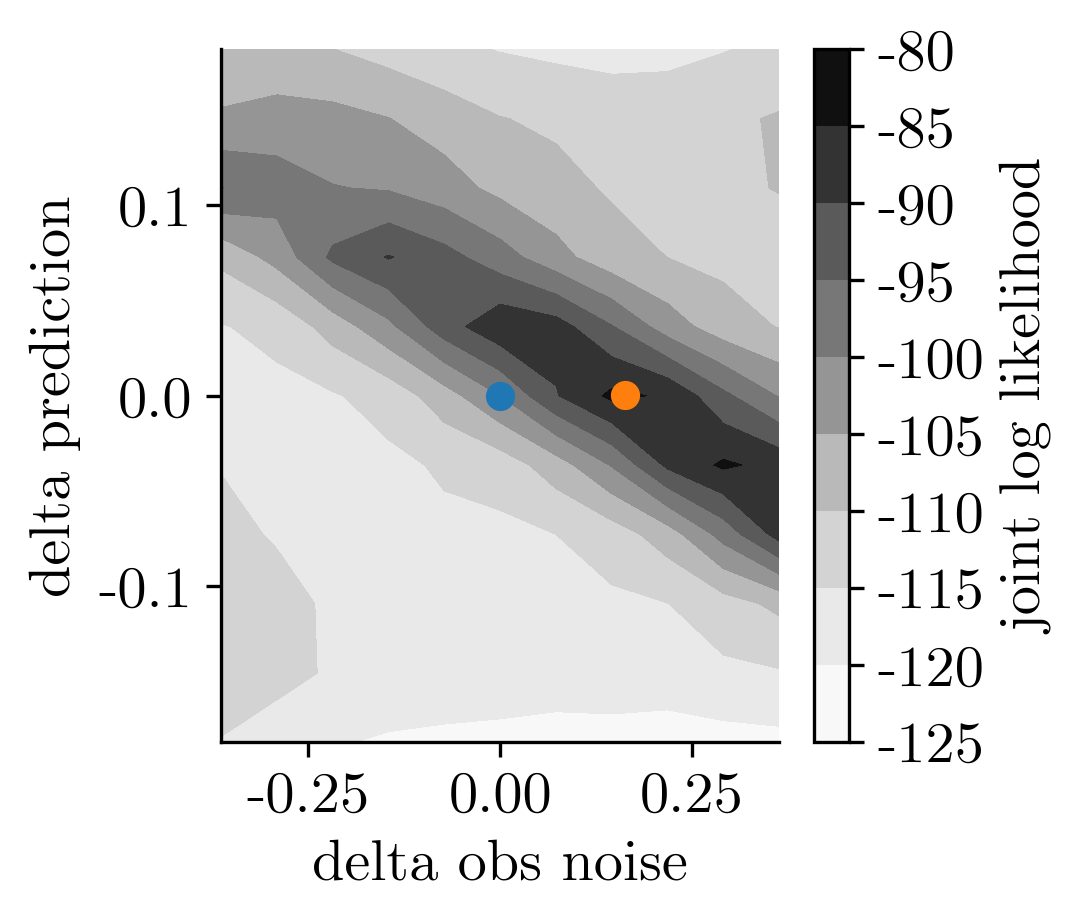

In [12]:

# vary two noise -----------------------------------------------
'''
        # vary process noise and obs noise.
        # calcualte the gains while keep bias same
'''
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1
dy[3]=1

auncertainty=mus[0][5]**2*mus[0][3]**2/(mus[0][5]**2+mus[0][3]**2)
huncertainty=(mus[1][5]**2*mus[1][3]**2)/(mus[1][5]**2+mus[1][3]**2)
abias=totalbias(mus[0][1],mus[0][3],mus[0][5])
hbias=totalbias(mus[1][1],mus[1][3],mus[1][5])

c=totalgivenop(mus[0][5],mus[0][3])
pogiventotal(mus[0][5],auncertainty)

X,Y=np.linspace(-0.4,0.4,gridreso),np.linspace(-0.2,0.2,gridreso) # on and pn
paramls=[]
z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        # vary process noise and obs noise.
        # calcualte the gains while keep bias same
        anewparam_=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        hnewparam_=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)

        anewpnoise=anewparam_[3]
        anewk = anewpnoise**2 / (anewparam_[5]**2+anewpnoise**2)
        anewg=abias/anewk
        anewparam_[1]=anewg


        hnewpnoise=hnewparam_[3]
        hnewk = hnewpnoise**2 / (hnewparam_[5]**2+hnewpnoise**2)
        hnewg=hbias/hnewk
        hnewparam_[1]=hnewg

        atheta=anewparam_.clone()
        htheta=hnewparam_.clone()
        paramls.append([atheta,htheta])
        z[i,j]=(atheta-htheta)[5]

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZtwonoisessmaller2finer19', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# vary obs and process noise, while keep bias the same (so we vary gains), result in vary uncertainties, smaller range
with open(datapath/'human/jointlikelihood/2noise2', 'rb') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
truedelta=mus[1]-mus[0]

# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     im=ax.imshow(formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='auto',vmin=-88, vmax=-73)
#     # im=ax.imshow(formatedZ[:-1,:],origin='lower', extent=(X[0],X[-2],Y[0],Y[-1]),aspect='auto',vmin=-103, vmax=-73)
#     # im=ax.contourf(formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),vmin=-103, vmax=-73)
#     ax.set_aspect('equal')
#     plt.colorbar(im,label='joint log likelihood') 
#     ax.scatter(0,0,label='zero') # midpoint, 0,0
#     ax.set_xlabel('delta obs noise')
#     ax.set_ylabel('delta pro noise')
#     ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
#     # ax.legend()
#     quickspine(ax)

def center_rotation(mat):
    new=np.zeros_like(mat)
    m,n=mat.shape
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            new[i,j]=mat[m-1-i, n-1-j]
    return new
sigma = 0.5     
formatedZ=center_rotation(gaussian_filter(formatedZ, sigma))

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.contourf(formatedZ,origin='lower', extent=(X[0],X[-1],Y[-1],Y[0]),cmap='Greys')
    # ax.set_aspect('equal')
    plt.colorbar(im,label='joint log likelihood') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta obs noise')
    ax.set_ylabel('delta prediction')
    ax.scatter(-truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()
    # plt.plot([theta_init[5], theta_final[5]],[theta_init[3],theta_final[3]])
    # plt.plot(ax.get_xlim(),-np.array(ax.get_xlim())*(theta_init[3]-theta_final[3]/(theta_init[5]-theta_final[5])).item())
    # plt.plot(ax.get_xlim(),np.array(ax.get_xlim())*-1)
    # plt.plot(theta_init[[5,3]],theta_final[[5,3]])
    quickspine(ax)
    # quicksave('vary 2 noise joint')





In [13]:

# kalman gain vs uncertainty ------------------------------------------

def getk(midpoint):
    return midpoint[5]**2/(midpoint[3]**2+midpoint[5]**2)

# ak=getk(mus[0])
# hk=getk(mus[1])
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1
dy[3]=1

X,Y=np.linspace(-0.2,0.2,gridreso),np.linspace(-0.7,0.7,gridreso) # k, uncertainty

paramls=[]
for i in range(gridreso):
    for j in range(gridreso):

        anewparam_=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        hnewparam_=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)

        anewpnoise=anewparam_[3]
        anewk = anewpnoise**2 / (anewparam_[5]**2+anewpnoise**2)
        anewg=abias/anewk
        anewparam_[1]=anewg


        hnewpnoise=hnewparam_[3]
        hnewk = hnewpnoise**2 / (hnewparam_[5]**2+hnewpnoise**2)
        hnewg=hbias/hnewk
        hnewparam_[1]=hnewg

        atheta=anewparam_.clone()
        htheta=hnewparam_.clone()
        paramls.append([atheta,htheta])



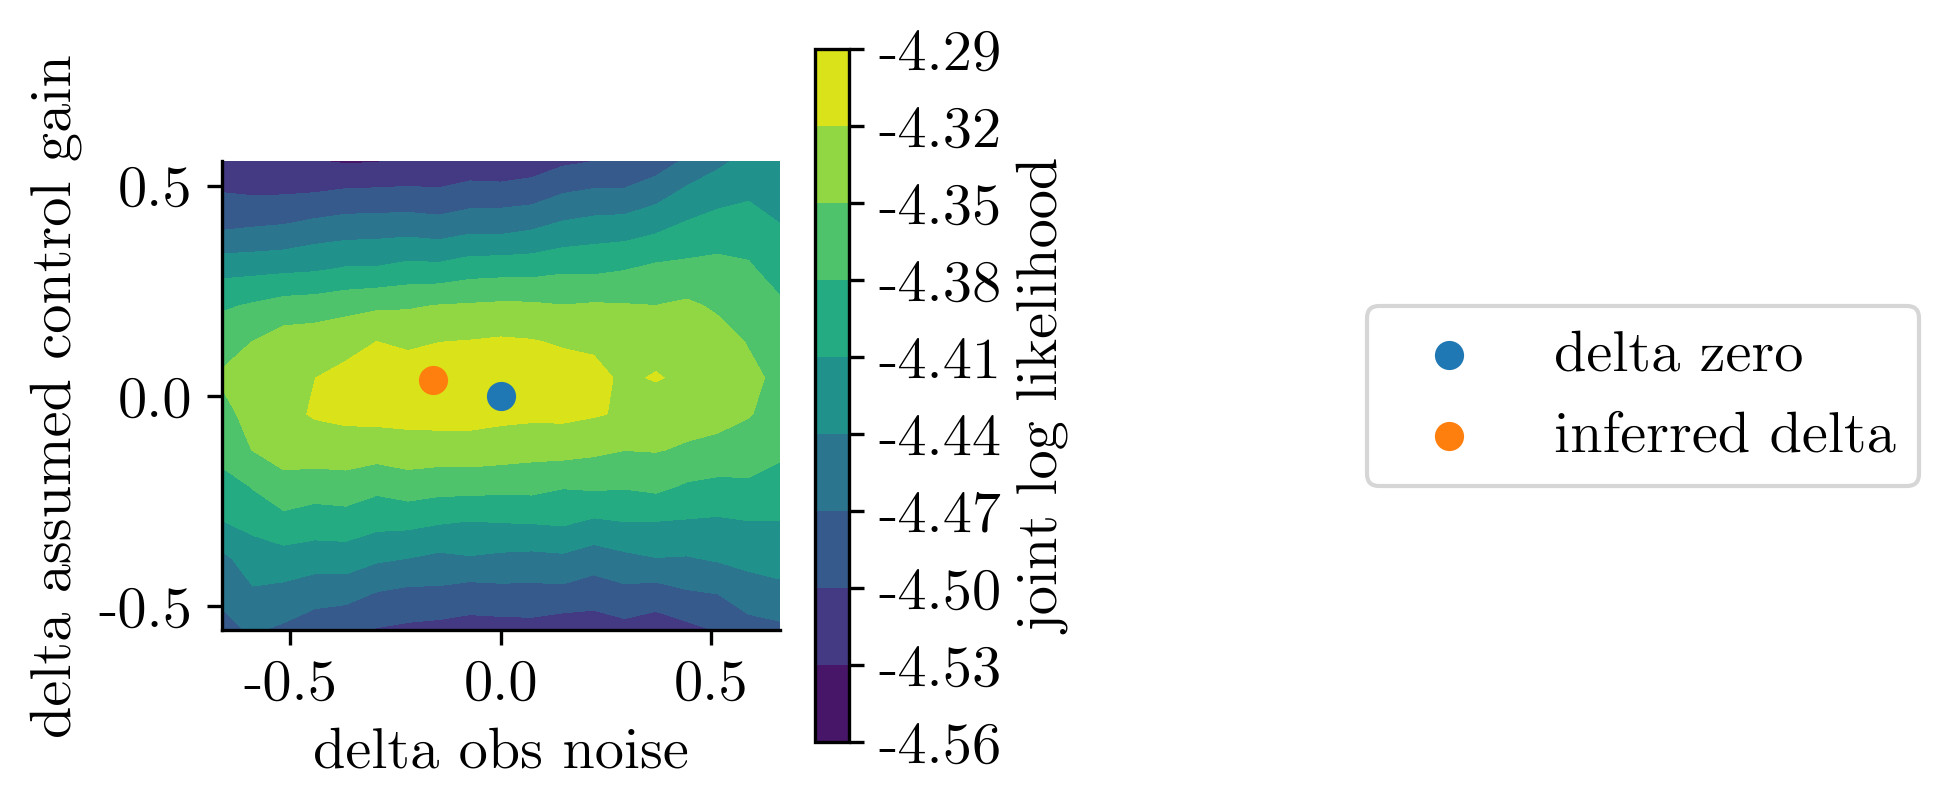

In [14]:


# bias vs uncertainty -----------------------------------------------------------
# vary obs noise and gain

'''
to vary the uncertainty, we vary po/(p+o)
the range is 0, 1/2
to vary the bias, we vary (1-k)*g, 
    where k=p/(p+o), thus pg/(p+o)
this is equvalent to vary o and g, while solve for p that fit the wantted uncertainty.
'''

X,Y=np.linspace(-0.7,0.7,gridreso),np.linspace(-1,1,gridreso) # o, gain
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1
dy[1]=1

paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        anewparam_=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        hnewparam_=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        # print(anewparam_[1],anewparam_[5])
        # print(hnewparam_[1],hnewparam_[5])
        paramls.append([anewparam_,hnewparam_])

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZgainonoisefiner19', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# vary gain and noise (vary bias vs uncertainty)
with open(datapath/'human/jointlikelihood/distinguishparamZgainonoisefiner19', 'rb') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
truedelta=mus[1]-mus[0]
X,Y=np.linspace(-0.7,0.7,gridreso),np.linspace(-1,1,gridreso) # o, gain

sigma = 0.5
formatedZ = gaussian_filter(formatedZ, sigma)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    # im=ax.imshow(formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]), aspect='auto')
    # im=ax.imshow(formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='auto',vmin=-84, vmax=-73)
    im=ax.contourf(-np.log(-formatedZ[2:-3]),origin='lower', extent=(X[0],X[-1],Y[2],Y[-3]))
    ax.set_aspect('equal')
    # ax.set_ylim(-0.5,0.5)
    plt.colorbar(im,label='joint log likelihood') 
    ax.scatter(0,0,label='delta zero') # midpoint, 0,0
    ax.set_xlabel('delta obs noise')
    ax.set_ylabel('delta assumed control gain')
    ax.scatter(truedelta[5]/2,truedelta[1]/2,label='inferred delta') # inferred delta
    ax.legend(loc='center left', bbox_to_anchor=(2, 0.5))
    quickspine(ax)


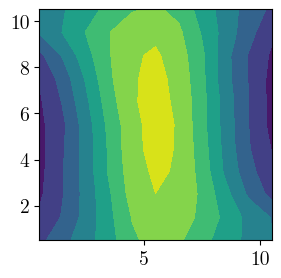

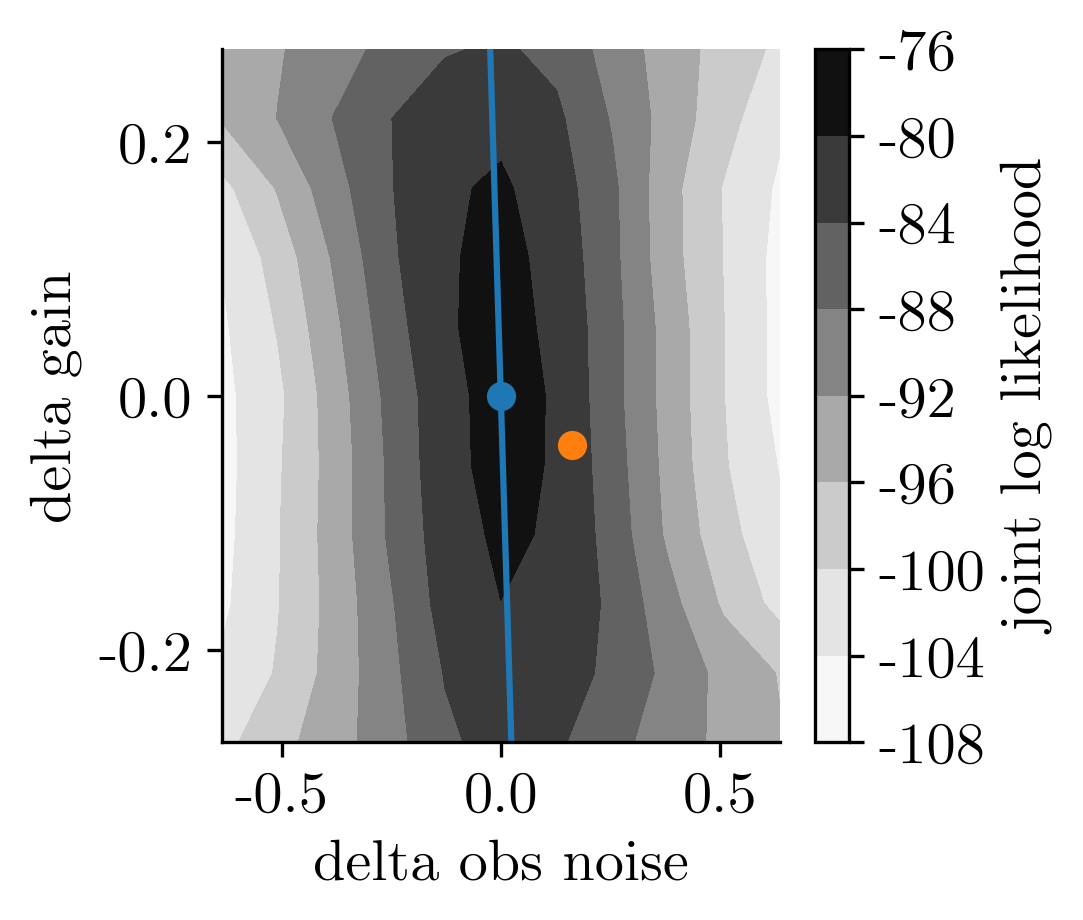

In [15]:

with open(datapath/'human/jointlikelihood/noisegain', 'rb') as f:
    paramls,Z= pickle.load(f)
Z=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5))
truedelta=mus[1]-mus[0]
X,Y=np.linspace(-0.7,0.7,gridreso),np.linspace(-0.3,0.3,gridreso) # o, gain
sigma = 0.5
formatedZ=center_rotation(gaussian_filter(Z, sigma))
plt.contourf(formatedZ, origin='image',)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.contourf((formatedZ),origin='image', extent=(X[0],X[-1],Y[0],Y[-1]),cmap='Greys')
    # ax.set_aspect('equal')
    plt.colorbar(im,label='joint log likelihood') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta obs noise')
    ax.set_ylabel('delta gain')
    ax.scatter(-truedelta[5]/2,-truedelta[1]/2,label='inferred delta') # inferred delta
    ax.set_ylim(ax.get_ylim())
    plt.plot(ax.get_xlim(),np.array(ax.get_xlim())*(theta_init[1]-theta_final[1]/(theta_init[5]-theta_final[5])).item())
    quickspine(ax)
    



In [16]:

# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     # im=ax.imshow(formatedZ[2:-2],origin='lower', extent=(X[0],X[-1],Y[2],Y[-3]), aspect='auto')
#     im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0],X[-1],Y[0],Y[-3]),aspect='auto',vmin=-103, vmax=-73)
#     # im=ax.contourf(formatedZ[2:-2],origin='lower', extent=(X[0],X[-1],Y[2],Y[-3]),vmin=-103, vmax=-73)
#     ax.set_aspect('equal')
#     plt.colorbar(im,label='joint log likelihood') 
#     ax.scatter(0,0,label='delta zero') # midpoint, 0,0
#     ax.set_xlabel('delta uncertainty')
#     ax.set_ylabel('delta prediction bias')
#     ax.scatter(truedelta[5]/2,truedelta[1]/2,label='inferred delta') # inferred delta
#     ax.legend(loc='center left', bbox_to_anchor=(2, 0.5))
#     quickspine(ax)

# ks,ss=transform2bs(paramls)
# plt.tricontourf(ks,ss,formatedZ.flatten(),3)

# # plot the bias instead of gain.
# # bias=assumed gain * (1-kalman gain)

# bs,ss=transform2bs(paramls)
# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     im=ax.imshow(formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]), aspect='auto')
#     ax.set_aspect('equal')
#     plt.colorbar(im,label='joint log likelihood') 
#     ax.scatter(0,0,label='delta zero') # midpoint, 0,0
#     ax.set_xlabel('delta obs noise')
#     ax.set_ylabel('delta assumed control gain')
#     ax.scatter(truedelta[5]/2,truedelta[1]/2,label='inferred delta') # inferred delta
#     ax.legend(loc='center left', bbox_to_anchor=(2, 0.5))
#     quickspine(ax)

# plt.tricontourf(bs,ss,formatedZ.flatten(),3)

# transform2bs([thetas.view(2,-1,1)])
# thetas.view(2,-1,1)[0]

In [17]:

'''
vary gain, and vary some other param. vary cost here.
'''
# vary gain and cost, show bias matters ------------------------

gridreso=17
X,Y=np.linspace(-0.45,0.45,gridreso),np.linspace(-1,1,gridreso) # cost, gain
dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 # cost
dy[1]=1 # gain

paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        anewparam_=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        hnewparam_=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        # print(anewparam_[1],anewparam_[5])
        # print(hnewparam_[1],hnewparam_[5])
        paramls.append([anewparam_,hnewparam_])

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZcostgain2', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('distinguishparamZcostgain2', 'rb+') as f:
#     paramls,Z= pickle.load(f)
# formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
# truedelta=mus[1]-mus[0]

# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     # im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='auto')
#     im=ax.imshow(formatedZ[:,1:-1],origin='lower', extent=(X[0],X[-1],Y[1],Y[-2]),aspect='auto',vmin=-103, vmax=-73)
#     # im=ax.contourf(formatedZ,origin='lower', extent=(X[2],X[-1],Y[0],Y[-1]),vmin=-103, vmax=-73)
#     ax.set_aspect('equal')
#     plt.colorbar(im,label='joint log likelihood') 
#     ax.scatter(0,0,label='zero') # midpoint, 0,0
#     ax.set_xlabel('delta w cost')
#     ax.set_ylabel('delta assumed control gain')
#     ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
#     # ax.legend()
#     quickspine(ax)




In [18]:

# show v does not matter
# vary v and w cost ----------------------------------------------------------------------
dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 
dy[7]=1 
X,Y=np.linspace(-0.45,0.3,gridreso), np.linspace(-0.9,0.9,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        atheta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        htheta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        # eval the logll
        # Z[i,j]=atheta,htheta
        paramls.append([atheta,htheta])

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('distinguishparamZvwcost2', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)
# [p[0][8] for p in paramls]
# [p[1][8] for p in paramls]

# # vary v and w cost
# with open('distinguishparamZvwcost2', 'rb+') as f:
#     paramls,Z= pickle.load(f)
# formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
# truedelta=mus[1]-mus[0]

# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     # im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='auto')
#     im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='equal',vmin=-103, vmax=-73)
#     plt.colorbar(im,label='joint log likelihood') 
#     ax.scatter(0,0,label='zero') # midpoint, 0,0
#     ax.set_xlabel('delta w cost')
#     ax.set_ylabel('delta v cost')
#     ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
#     # ax.legend()
#     quickspine(ax)


In [ ]:

# vary v and w gain ----------------------------------------------------------------------
dx,dy=np.zeros((11)),np.zeros((11))
dx[1]=1 
dy[0]=1 
X,Y=np.linspace(-1,1,gridreso) , np.linspace(-1,1,gridreso) 
paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        atheta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        htheta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append([atheta,htheta])
# Z=ray.get([getlogll.remote(each) for each in paramls])

# with open('distinguishparamZvwgain', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)





In [19]:


# vary two noises w for burno pert data ----------------------------------------------

'''
we found that process noise w and obs noise w are possitively correlated,
test if this is true
by varying the two parameters
'''
# load the data
num_sample=300
theta,_,_=process_inv("Z:/bruno_pert/cmafull_b_pert", removegr=False)
with open('Z:/victor_pert/packed','rb') as f:
    df = pickle.load(f)
df=datawash(df)
df=df[df.category=='normal']
df=df[df.target_r>200]
states, actions, tasks=monkey_data_downsampled(df,factor=0.0025)
states, actions, tasks=states[:num_sample], actions[:num_sample], tasks[:num_sample]
# vary the two params
base=np.array(theta).reshape(-1)
base[3]=0
base[5]=0
gridreso=15
dx,dy=np.zeros((11)),np.zeros((11))
dx[3]=1 # pro noise
dy[5]=1 # obs noise
X,Y=np.linspace(0,2,gridreso), np.linspace(0,2,gridreso)
paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        htheta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(htheta)

# logll function
env=ffacc_real.FireFlyPaper(arg)
phi=torch.tensor([[0.5],
            [pi/2],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
            [0.13],
            [0.001],
            [0.001],
            [0.001],
            [0.001],
    ])
agent_=TD3.load('trained_agent/paper.zip')
agent=agent_.actor.mu.cpu()
@ray.remote
def getlogll(x):
    if torch.any(x>2) or torch.any(x<=0):
        return None
    with torch.no_grad():
        return  monkeyloss_(agent, actions, tasks, phi, torch.tensor(x).view(-1,1), env, action_var=0.01,num_iteration=1, states=states, samples=5,gpu=False).item()

# Z=ray.get([getlogll.remote(each) for each in paramls])
# with open('varytwonoiseburnopert', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('varytwonoiseburnopert', 'rb') as f:
#     paramls,Z= pickle.load(f) 

# formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
# with initiate_plot(3,3,300) as f:
#     ax=f.add_subplot(111)
#     im=ax.imshow(-formatedZ,origin='lower', extent=(X[0],X[-1],Y[0],Y[-1]),aspect='equal')
#     plt.colorbar(im,label='log likelihood') 
#     ax.set_xlabel('process noise w')
#     ax.set_ylabel('obs noise w')
#     quickspine(ax)
    # quicksave('two noise log likelihood burno pert')




Z:/bruno_pert/cmafull_b_pert


FileNotFoundError: [Errno 2] No such file or directory: 'Z:/bruno_pert/cmafull_b_pert'

In [20]:


# vary along pc direction ----------------------------------------------
# background ---------------------

# load data
datapath=Path("Z:\\bruno_pert\\packed")
with open(datapath,'rb') as f:
    df = pickle.load(f)
df=datawash(df)
df=df[df.category=='normal']
df=df[df.target_r>200]
states, actions, tasks=monkey_data_downsampled(df[:100],factor=0.0025)

# from cov, find the eig axis we are most sure about
theta,cov,err=process_inv("Z:/bruno_pert/cmafull_packed_bruno_pert", removegr=False)
ev, evector=torch.linalg.eig(torch.tensor(cov),eigenvectors=True)
ev=ev[:,0]
ev,esortinds=ev.sort(descending=False)
evector=evector[:,esortinds]
axis1=evector[:,0].reshape(-1,1)
axis2=evector[:,1].reshape(-1,1)

# vary the two axis to cover the possible range, calculate the backgrond and plot
# X=np.linspace(-1.2,0.085,15)
# Y=np.linspace(-0.3,0.195,15)
# vary by eig value
gridreso=11
numev=6
X,Y=np.linspace(-1,1,gridreso)*ev[0].item()*numev,np.linspace(-1,1,gridreso)*ev[1].item()*numev

paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        htheta=torch.tensor(axis1*X[i]+axis2*Y[j]+theta).float().view(-1,1)
        paramls.append(htheta)
[1  for pp  in paramls if torch.any(pp<0)]

print('starting background')
Z=ray.get([getlogll.remote(each) for each in paramls])
with open('background bruno pert', 'wb+') as f:
        pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)
with open('background bruno pert', 'rb') as f:
    paramls,Z= pickle.load(f) 
# Z=normalizematrix(Z)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T

masked_array = np.ma.masked_invalid(formatedZ.astype('float'))
cmap = matplotlib.cm.get_cmap()
cmap.set_bad('black',1.)
im=plt.contourf(masked_array[:-2,:-2]*-1, levels=[-30,-20,-15,-14,-13,-12],interpolation='nearest', cmap=cmap)
plt.colorbar(im)


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\bruno_pert\\packed'

In [ ]:

# project the inverse trajectory onto the background

sys.exit()
for i in range(11):
    print(i)
    print(min([pp[i] for pp in paramls]),(max([pp[i] for pp in paramls])))
    
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0]+midpoint[8],X[-1]+midpoint[8],Y[0]+midpoint[7],Y[-1]+midpoint[7]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta w cost')
    ax.set_ylabel('delta v cost')
    # ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()


In [ ]:


def tmp(name):
    with open(name, 'rb') as f:
        slog = pickle.load(f)
    log=slog
    res=[l[2] for l in log]
    allsamples=[]
    alltheta=[]
    loglls=[]
    for r in res:
        for point in r:
            alltheta.append(torch.tensor(point[0]))
            loglls.append(torch.tensor(point[1]))
            allsamples.append([point[1],point[0]])
    alltheta=torch.stack(alltheta)
    logllsall=torch.tensor(loglls).flatten()
    allsamples.sort(key=lambda x: x[0])
    allthetameans=np.array([l[0]._mean for l in log])
    alltheta=alltheta[50:]
    logllsall=logllsall[50:]
    mu=np.mean(np.asfarray(alltheta),0).astype('float32')
    score, evectors, evals = pca(np.asfarray(alltheta))
    x=score[:,0] # pc1
    y=score[:,1] # pc2
    z=logllsall
    npixel=9

    finalcov=log[-1][0]._C
    realfinalcov=np.cov(np.array([l[0] for l in log[-1][2]]).T)

    finaltheta=log[-1][0]._mean
    pcfinaltheta=((finaltheta.reshape(-1)-mu)@evectors).astype('float32')
    finalcovpc=(evectors.T@finalcov@evectors).astype('float32')
    realfinalcovpc=(evectors.T@realfinalcov@evectors).astype('float32')
    pccov=evectors.T@(np.cov(alltheta.T))@evectors
    allthetameanspc=((allthetameans-mu)@evectors).astype('float32')
    with initiate_plot(3, 3.5, 300) as fig, warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ax = fig.add_subplot(111)
        plot_cov_ellipse(pccov[:2,:2], pcfinaltheta[:2], alpha=0.3,nstd=1,ax=ax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        s = ax.scatter(x,y, c=z,alpha=0.5,edgecolors='None', cmap='jet')
        ax.set_xlabel('projected parameters')
        ax.set_ylabel('projected parameters')
        c = fig.colorbar(s, ax=ax)
        ax.locator_params(nbins=3, axis='y')
        ax.locator_params(nbins=3, axis='x')
        # c.clim(min(np.log(loglls)), max(np.log(loglls))) 
        c.set_label('- log likelihood')
        # c.set_ticks([min((loglls)),max((loglls))])
        c.ax.locator_params(nbins=4)
        # ax.set_xlim(xlow,xhigh)
        # ax.set_ylim(ylow,yhigh)
        ax.plot(allthetameanspc[:,0],allthetameanspc[:,1])

# name='Z:/bruno_pert/testtemp3packed_bruno_pert'
# process_inv(name)
# tmp(name)

In [23]:

# vary v and w cost, eval the curvature   ----------------------------------------------
# ASD-health

# curvature 1, total angle turned---------------------------------------------------
datapath=Path(datafolder)/"human/hgroup"
with open(datapath, 'rb') as f:
    hstates, hactions, htasks = pickle.load(f)
res=[]
for task in htasks:
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/5*0.7 or a>=pi/5*0.7:
        res.append(task)
sidetasks=np.array(res)

sidetasks=sidetasks[:100]

@ray.remote
def getcur(x):
    x.clamp_(1e-3,3)
    with torch.no_grad():
        curvature=eval_curvature(agent, env, phi, x,sidetasks,vctrl=0.,wctrl=0.,ntrials=50)
        return  curvature

dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 
dy[7]=1 

X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        theta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(theta)

# Z=ray.get([getcur.remote(each) for each in paramls])

# with open('distinguishparamZvwcostcurvaturesingle', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# vary v and w cost, heatmap of curvature
with open('distinguishparamZvwcostcurvaturesingle', 'rb+') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0]+midpoint[8],X[-1]+midpoint[8],Y[0]+midpoint[7],Y[-1]+midpoint[7]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta w cost')
    ax.set_ylabel('delta v cost')
    # ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()


FileNotFoundError: [Errno 2] No such file or directory: 'distinguishparamZvwcostcurvaturesingle'

In [ ]:

# using curvature 2, the furthest point -----------------------------------------------------
def eval_curvature2(agent, env, phi, theta, tasks,ntrials=10):
    costs=[]
    states=[]
    with suppress():
        for task in tasks:
            while len(states)<ntrials:
                env.reset(phi=phi, theta=theta, goal_position=task, pro_traj=None,vctrl=0.,wctrl=0. )
                _,_,_,epstates=run_trial(agent,env,given_action=None, given_state=None, action_noise=0.1)
                if len(epstates)>5:
                    states.append(torch.stack(epstates)[:,:,0])
    for s in states:
        end=s[-1][:2]
        rotation=xy2pol(end,rotation=False)[1].item()
        R=np.array([[np.cos(rotation),np.sin(rotation)],[-np.sin(rotation),np.cos(rotation)]])
        rotatedxy=R@np.array(astates[i][:,:2].T)
        epcost=np.max(rotatedxy[1])
        costs.append(epcost)    
    return sum(costs)

@ray.remote
def getcur(x):
    x.clamp_(1e-3,3)
    with torch.no_grad():
        curvature=eval_curvature2(agent, env, phi, theta, [None]*50, ntrials=50)
        return  curvature

dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 
dy[7]=1 

X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        theta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(theta)

# Z=ray.get([getcur.remote(each) for each in paramls])

# with open('distinguishparamZvwcostcurvature2', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:

# vary v and w cost, heatmap of curvature
with open('distinguishparamZvwcostcurvature2', 'rb+') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0]+midpoint[8],X[-1]+midpoint[8],Y[0]+midpoint[7],Y[-1]+midpoint[7]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta w cost')
    ax.set_ylabel('delta v cost')
    # ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()



def transform2ks(paramls):
    # transform the param list to kalman gain vs total uncertainty 
    ks=[] # kalman gain diffs
    for ta, th in paramls:
        ks.append((getk(ta)-getk(th)).item())
    ss=[] # uncertainty diffs
    for ta, th in paramls:
        ss.append((totalgivenop(ta[3],ta[5])-totalgivenop(th[3],th[5])).item())

    plt.scatter(ks,ss)
    return ks,ss

def transform2bs(paramls):
    # transform the param list to controlgain*(1-kalman gain) vs total uncertainty 
    ks=[] # kalman gain diffs
    for ta, th in paramls:
        ks.append((ta[1]*(1-getk(ta))-th[1]*(1-getk(th))).item())
    ss=[] # uncertainty diffs
    for ta, th in paramls:
        ss.append((totalgivenop(ta[3],ta[5])-totalgivenop(th[3],th[5])).item())

    plt.scatter(ks,ss)
    return ks,ss

